## Comparison feature for QA4SM

The QA4SM web application service allows to validate one or more satellite soil moisture datasets against a reference. When a validation is run (after logging in, at `https://qa4sm.eu/validate/`), a netCDF result file is produced containing metadata and results by validation metric. 

Through the service it is possible to validate multiple satellite datasets against the same reference, therefore producing a horizontal comparison of the satellite products. However, this comparison is constrained by having the same temporal and spatial subsets, as well as scaling method, applied in all validations. Comparing the performance of a satellite product across for instance different time periods or areas of the Earth is possibly of great added value to the user, but currently not implemented in the service. To make up for this, a new feature is to be implemented in the web application in the form of a separate web page, where different validations can be drawn from the user's archive and compared to one another.

This notebook gives an overview of the concept for comparison of validation results. It is currently being developed in the [qa4sm-reader package](https://github.com/awst-austria/qa4sm-reader) QA4SMComparison Class. 

The Class can be initialized by giving a list of paths to netCDF result files. At the moment, all functionalities in the class (plots and table) work when the paths list includes 2 validations where the same reference is compared to one single satellite dataset (e.g A:B against A:C). A few plotting functions (`diff_plot()` and `diff_boxplot()`) can also work with more then three validations (e.g. A:B against A:C against A:D) or validations containing multiple comparison satellite datasets (e.g. A:B against A:C,D). However, for the moment the simplest case is considered where the same reference is compared to two distinct datasets.   

In [31]:
from qa4sm_reader.comparing import QA4SMComparison
import qa4sm_reader.globals
import os

os.chdir('/home/pstradio/Projects/qa4sm-reader/docs/examples/example_data/validations_nc')

# two validations only differ by validation period
paths = ['ISMN_ref/0-ISMN.soil moisture_with_1-C3S.sm.2017-18.nc', 'ISMN_ref/0-ISMN.soil moisture_with_1-C3S.sm.2018-19.nc']

comp = QA4SMComparison(paths)

# the comparison attribute is a dictionary with {path: ID, QA4SMImg}.
#each image is assigned a name that identifies it, together with the ID:
for n, img in comp.comparison.values():
    print("{}-{}".format(n, img.name))

0-ISMN v C3S(2017-11-01 to 2018-12-01)
1-ISMN v C3S(2018-11-01 to 2019-12-31)


The names of the images are fundamental to tell apart the different validation results. These same names are used in the plots and table and should be unambiguous. In this case, the two validations only differ by time period and can be easily identified by includig this in the name. However, if the purpose is to compare validations with different e.g. scaling options or extents, **a different method has to be identified!**


### Comparing different spatial subsets

Different validations may use different spatial subsets, which can completely overlap, intersect or correspond to entirely separate regions. This can create problems as some of the comparison methods depend on point-wise comparisons. Specifically, maps and difference and correlation plots provide a comparison result that is calculated point-by-point. These methods therefore cannot be used to compare validations with non-overlapping spatial extents. For all the other methods, the comparison class offers two choices (specified in the class call with the parameter `where`) to get the 'union' or 'intersection' of the spatial subsets.

For instance, if we select a spatial subset over continental Europe and perform a validation:
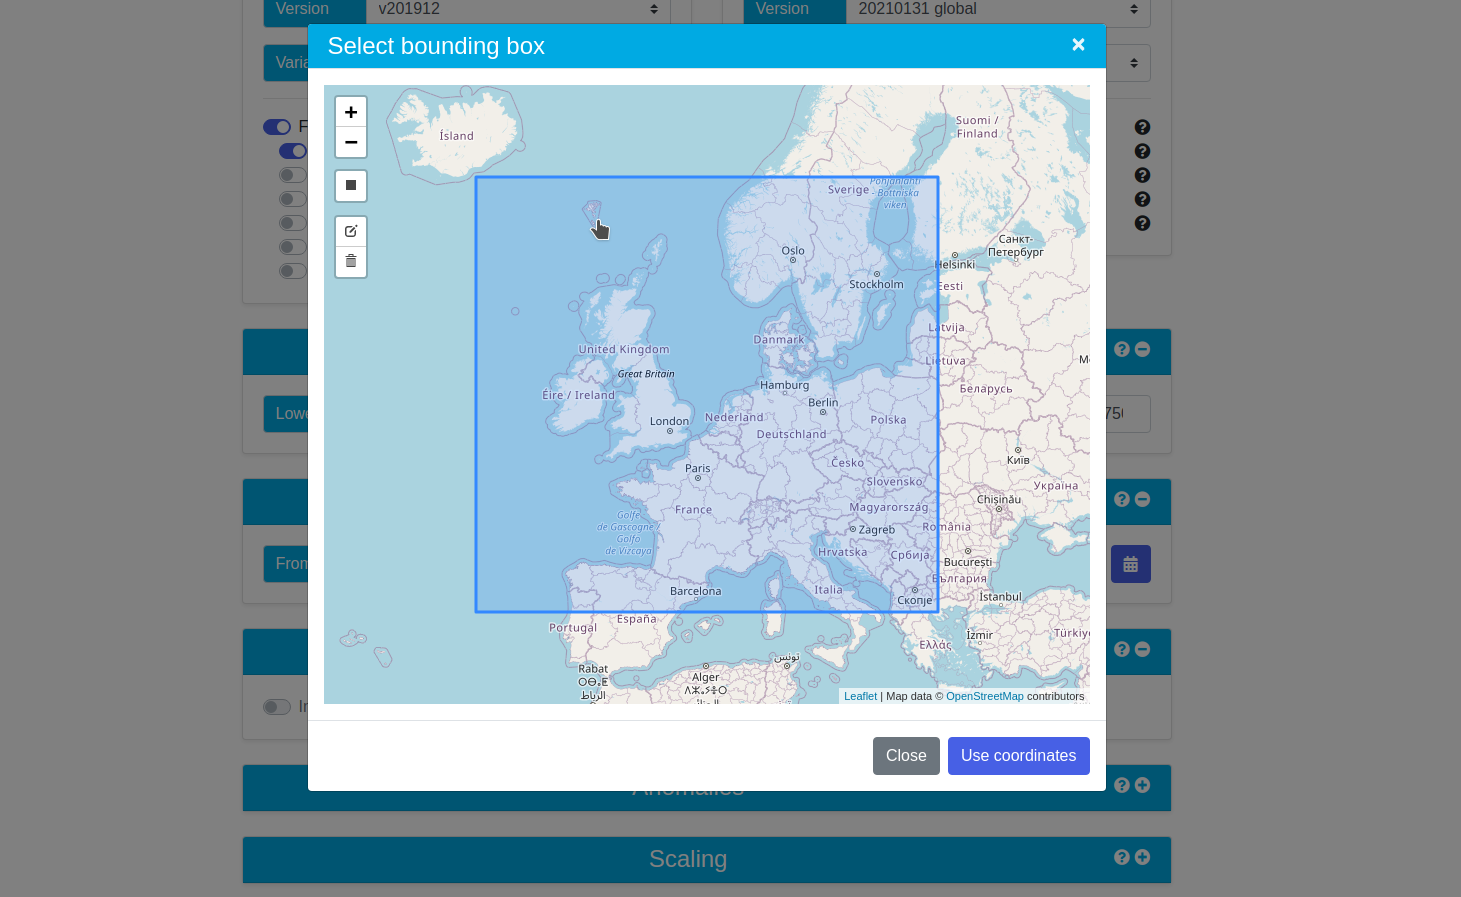

And we perform a validation with the same datasets over a partially overlapping spatial subset:
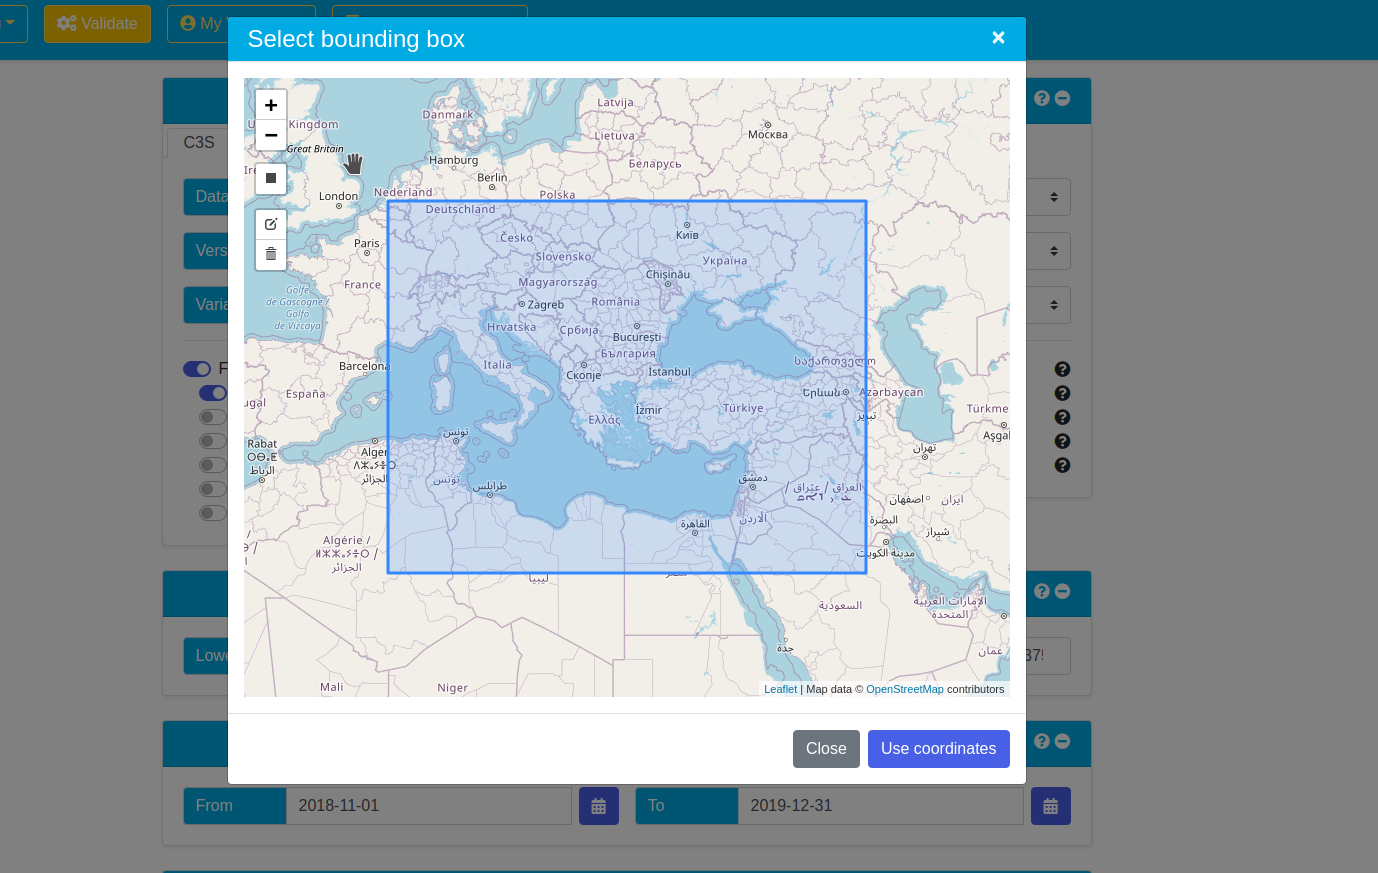

In [32]:
from qa4sm_reader.img import QA4SMImg

# paths to the validations with different spatial selections:
paths_subsets = ['Spatial_subsets/0-ISMN.soil moisture_with_1-C3S.sm.continental.nc', 'Spatial_subsets/0-ISMN.soil moisture_with_1-C3S.sm.southeast.nc']

for path in paths_subsets:
    img = QA4SMImg(path)
    print('Spatial extent of a single image:', img.extent)

comp_subsets_union = QA4SMComparison(paths_subsets, where='union')  # union of the spatial subsets
comp_subsets_inters = QA4SMComparison(paths_subsets, where='intersection')  # intersection of the spatial subsets
    
print('Spatial extent of the union:', comp_subsets_union.extent)
print('Spatial extent of the intersection:', comp_subsets_inters.extent)

Spatial extent of a single image: (-5.5919, 23.1129, 41.18264, 56.0426)
Spatial extent of a single image: (4.34483, 27.64438, 43.88367, 51.13274)
Spatial extent of the union: (-5.5919, 27.64438, 41.18264, 56.0426)
Spatial extent of the intersection: (4.34483, 23.1129, 43.88367, 51.13274)


#### Difference table

A first difference overview can be provided using the summary statistics of the validation results. In the table, an absolute and relative difference value between the medians of the two datasets is associated to each validation metric:

In [33]:
# just suppress warning for nans
import warnings
warnings.filterwarnings('ignore')
comp.diff_table()

,Medians for ISMN v C3S(2017-11-01 to 2018-12-01),Medians for ISMN v C3S(2018-11-01 to 2019-12-31),Difference of medians (source - reference)
Metric,,,
# observations,3.1e+02,5.1e+01,-2.6e+02
Pearson's r [-],3.6e-01,1.8e-01,-1.8e-01
Pearson's r p-value [-],1.5e-10,2.0e-01,2.0e-01
Spearman's rho [-],3.7e-01,2.0e-01,-1.7e-01
Spearman's rho p-value [-],2.3e-10,1.5e-01,1.5e-01
Root-mean-square deviation [m³/m³],4.8e-02,4.4e-02,-4.0e-03
Bias (difference of means) [m³/m³],-1.1e-08,6.7e-09,1.8e-08
Unbiased root-mean-square deviation [m³/m³],4.8e-02,4.4e-02,-4.0e-03
Mean square error [(m³/m³)²],2.3e-03,1.9e-03,-3.7e-04


* **any ideas on how the table can be made more informative?**

#### Difference boxplot

The difference boxplot can be considered an extension of the boxplot utility to visualize the results of a single validation (on the [results page of QA4SM](https://qa4sm.eu/myruns/)). The boxplot can potentially accomodate any number of validations; the inter-validations comparison would look exactly the same for boxplots except that we are comparing e.g. 2 different years:

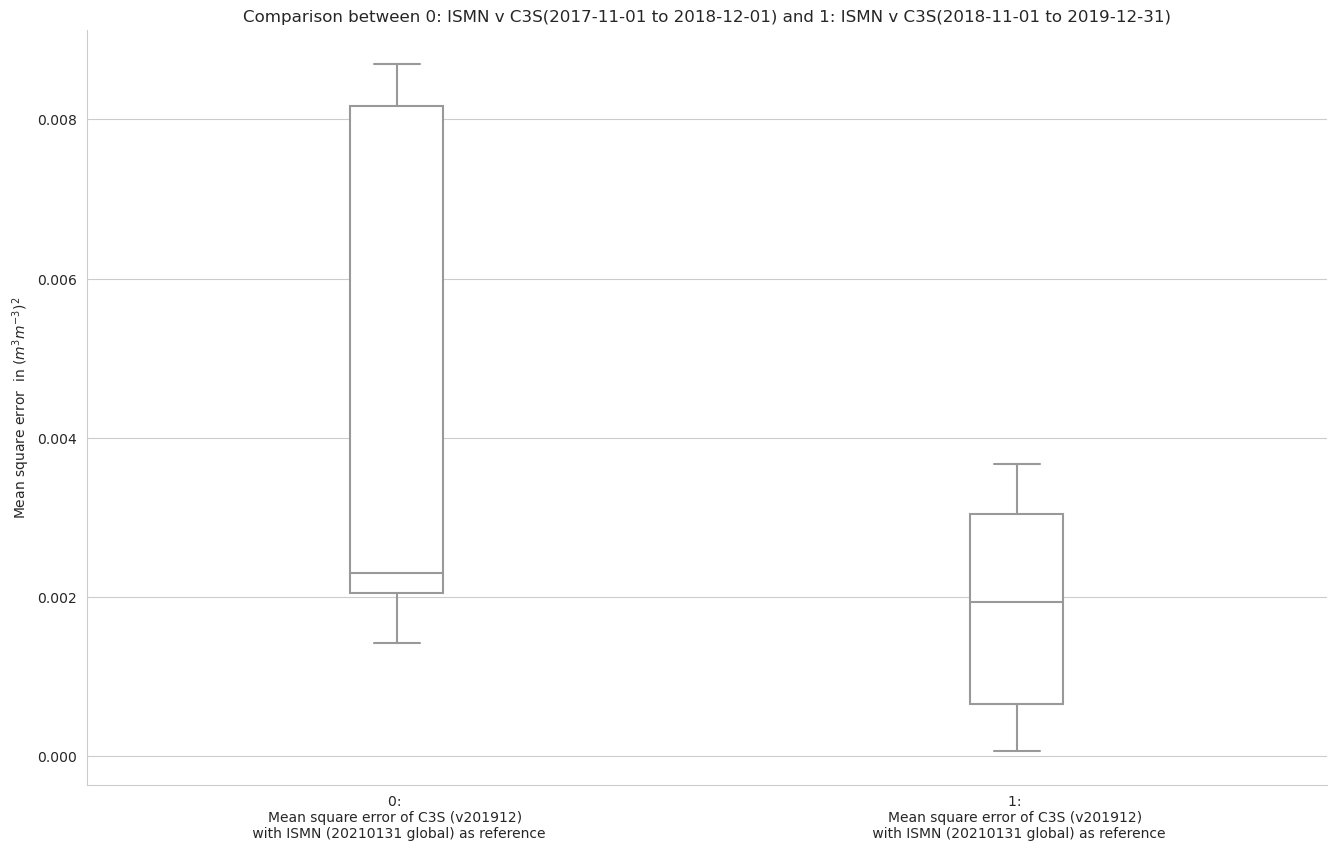

In [34]:
comp.diff_boxplot('mse')

Alternatively, a boxplot of the pairwise differences between the two validations could be shown, together with the individual results of the two validations:

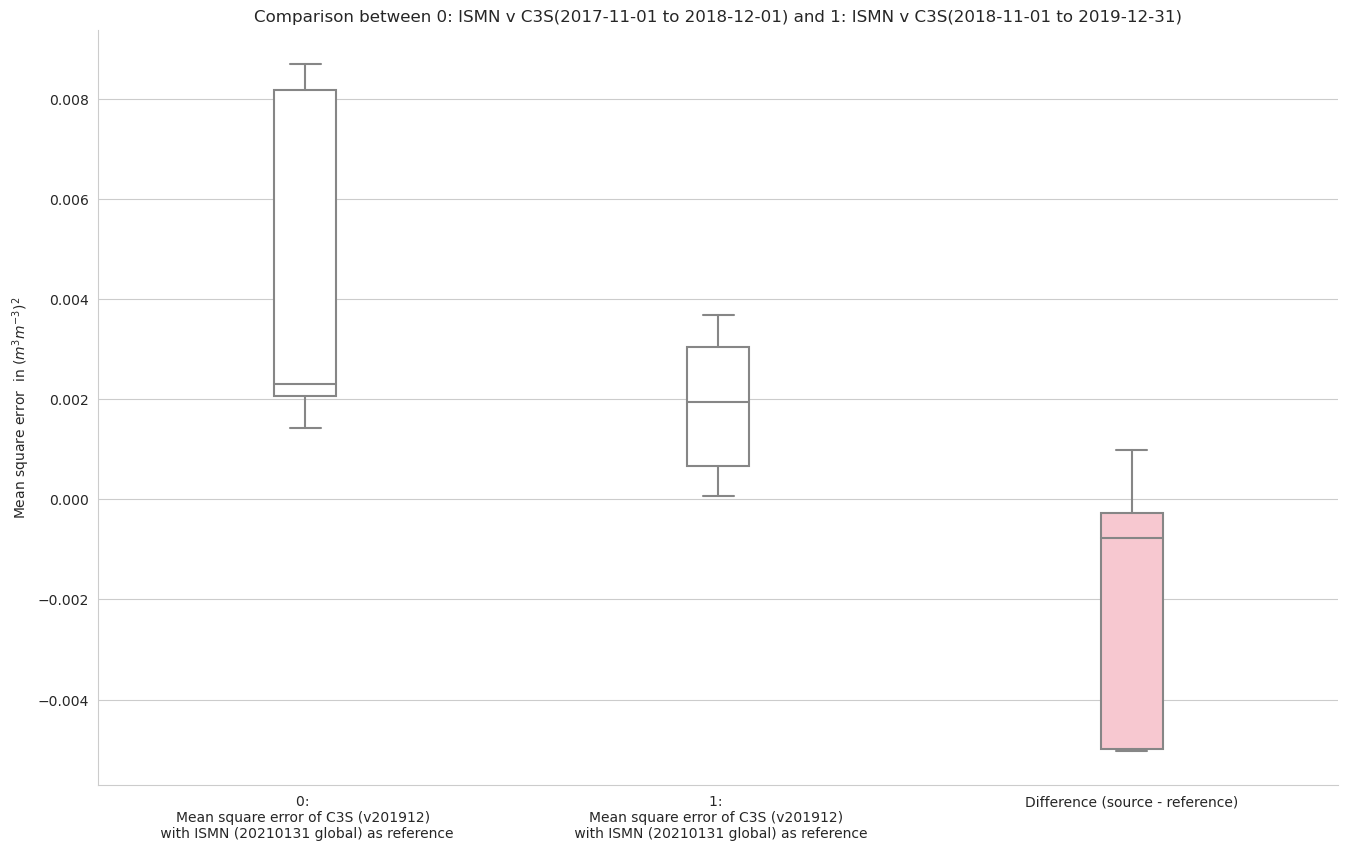

In [35]:
comp.diff_bplot_extended('mse')

A simple boxplot has the advantage of allowing for comparison with more than 2 validations:

* **Is the multi-comparison a feature that is worth working on?**

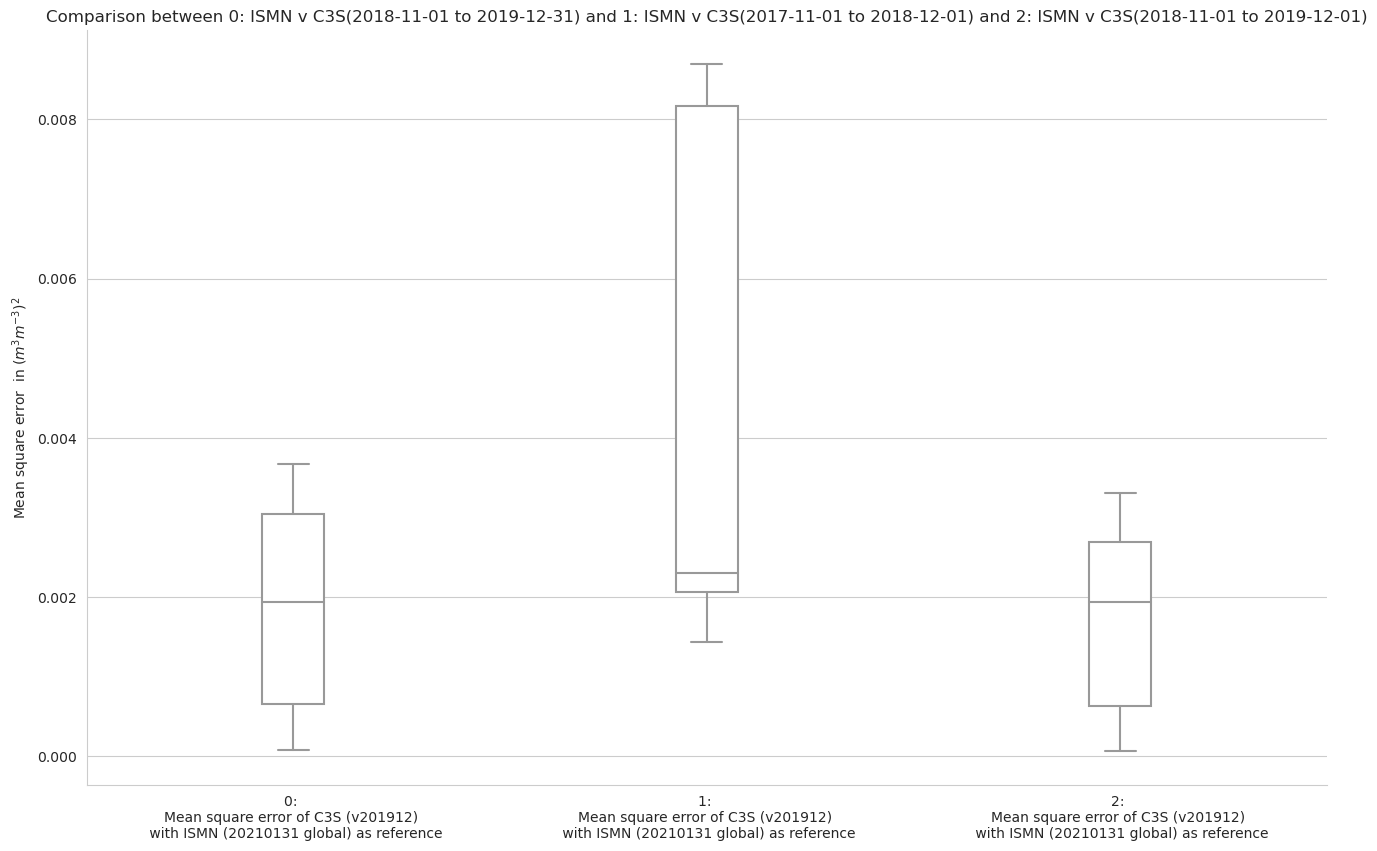

In [42]:
# adding a third validation
ext_paths = ['ISMN_ref/0-ISMN.soil moisture_with_1-C3S.sm.2018-19.nc',
             'ISMN_ref/0-ISMN.soil moisture_with_1-C3S.sm.2017-18.nc',
             'ISMN_ref/0-ISMN.soil moisture_with_1-C3S.sm.beta_match.nc']

ext_comp = QA4SMComparison(ext_paths)

ext_comp.diff_boxplot('mse')

#### Difference mapplot

A mapplot provides spatial information on the difference of performance between two validations. Below are different options to visualize the colorbar, according to the value of `diff_range`. **Which is the best option?**

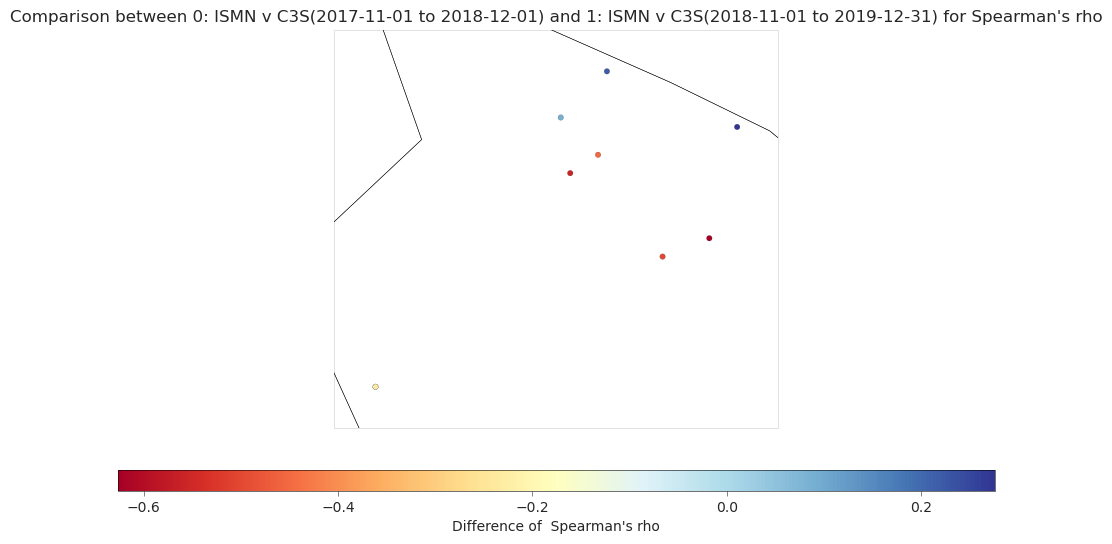

In [37]:
# metric needs to be specified. 'adjusted' has the colorbar going from the minimum to the maximum value
comp.diff_mapplot('rho', diff_range='adjusted')

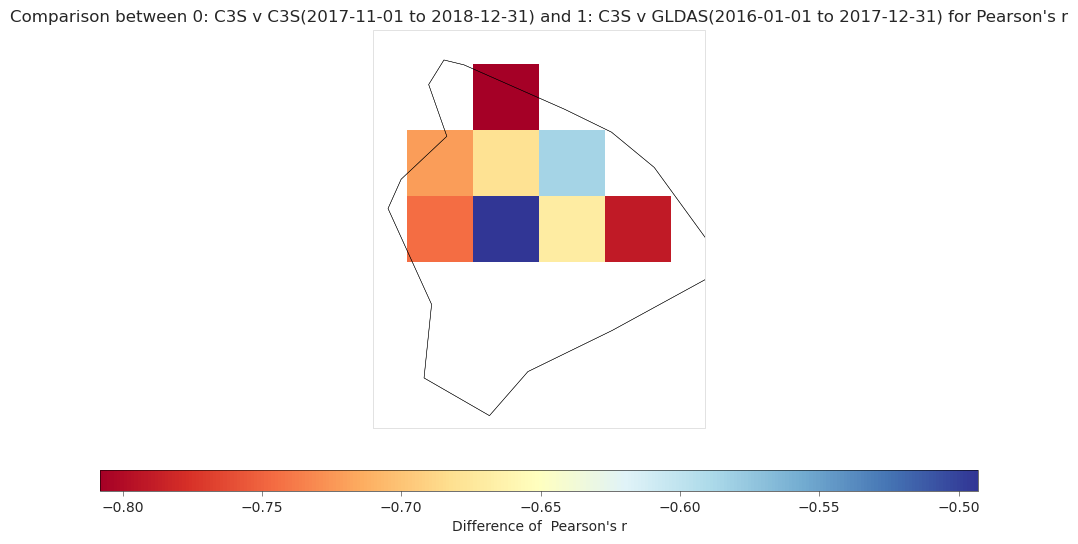

In [38]:
gridded = ['Gridded_comparison/0-C3S.sm_with_1-C3S.sm.nc', 'Gridded_comparison/0-C3S.sm_with_1-GLDAS.SoilMoi0_10cm_inst.nc']
gridded_comp = QA4SMComparison(gridded)

gridded_comp.diff_mapplot('R')



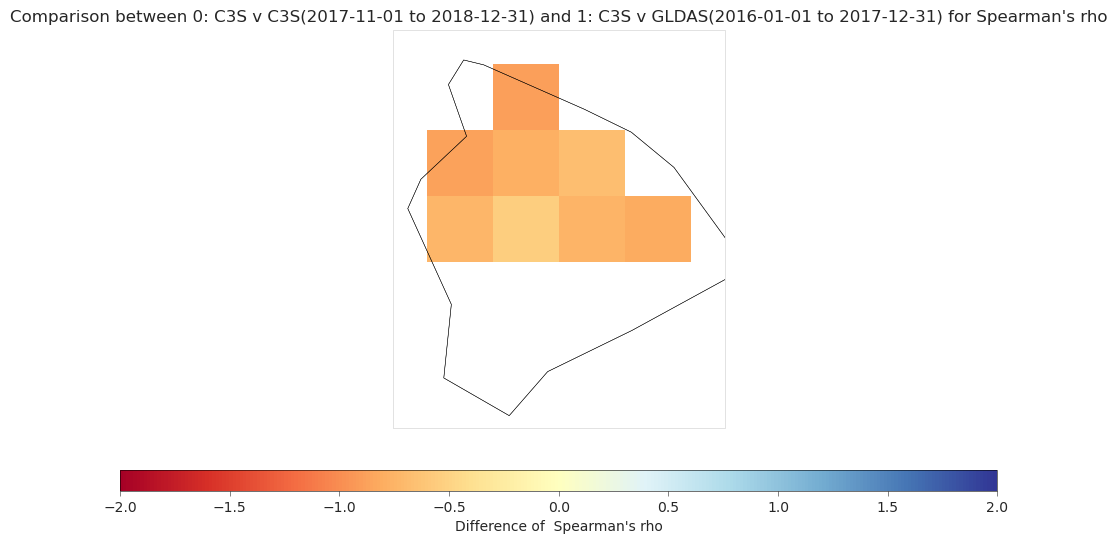

In [39]:
# metric needs to be specified. 'adjusted' has the colorbar going between fixed min and max, e.g.:
# for Pearson'r r -> [-2, 2]
gridded_comp.diff_mapplot('rho', diff_range='fixed')

#### Difference plot

Another mean to provide a direct comparison between two or more validation results is a difference plot (Bland-Altman plot). This plots the mean against the difference of the values between two validation results; it is generally used to verify the agreement between two methods, but can also be visually interpreted to see whether there is a progressive difference in the results, for a certain metric:

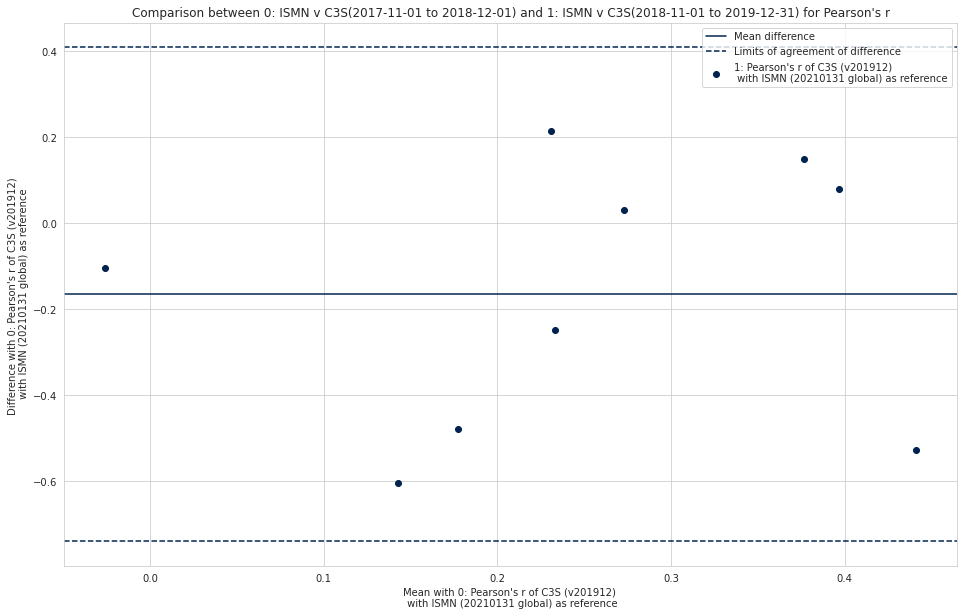

In [40]:
comp.diff_plot('R')

#### Correlation plot

A correlation plot could show whether e.g. a dataset performs consistently throughout time, and whether there are strong outliers. Using a regression cal also show which of the two terms of comparison is performing better (i.e. if the slope is skewed on one side).

* **Should we make possible to have multiple comparisons plotted on the same image?**

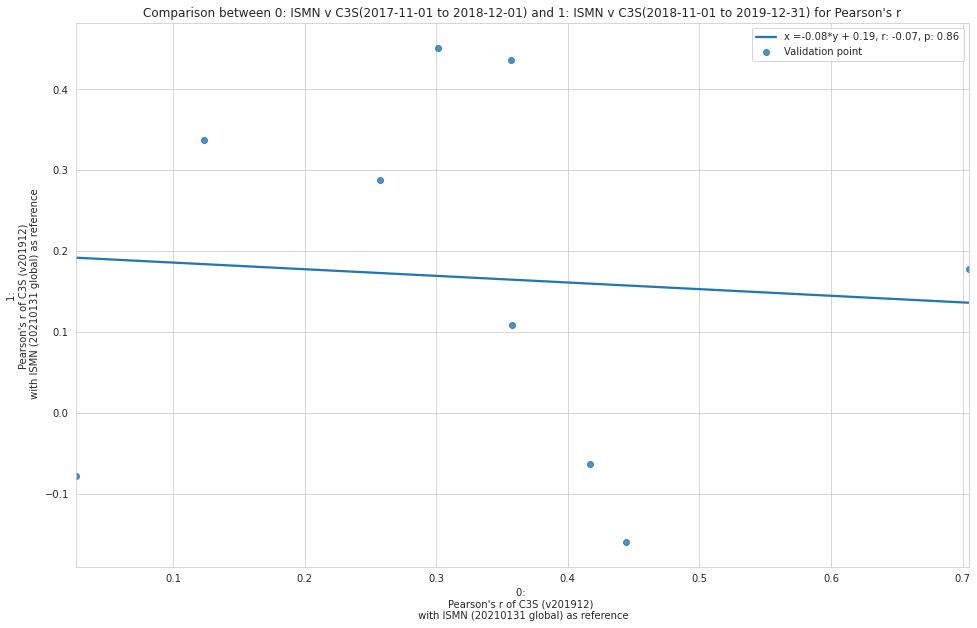

In [41]:
comp.corr_plot('R', **{'ci':0})